In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import IPython.display
import librosa.display
import numpy as np
import librosa
import tensorflow as tf
import glob

### If you have been save the data, you don't have to preprocessing and save the data

In [2]:
drone_path = '../../data/inner10m/*.wav'
background_path = '../../data/background/*.wav'

drone_files = glob.glob(drone_path)
background_files = glob.glob(background_path)

In [3]:
CHUNK_SIZE = 8192
SR = 22050
N_MFCC = 16

In [4]:
def load(files, sr=22050):
    [raw, sr] = librosa.load(files[0], sr=sr)
    for f in files[1:]:
        [array, sr] = librosa.load(f, sr=sr)
        raw = np.hstack((raw, array))
    print(raw.shape)
    return raw

In [5]:
drone_raw = load(drone_files)
background_raw = load(background_files)

(4464640,)
(6032517,)


# Data preprocessing

Chose `mfcc4` among functions below:
- input size 16x16; `n_mfcc=16`, used first 16 data points from 16x17 mfcc of a chunk with size 8192
- chunk siez 8192, overlapped half of it

In [6]:
def mfcc4(raw, label, chunk_size=8192, window_size=4096, sr=22050, n_mfcc=16, n_frame=16):
    mfcc = np.empty((0, n_mfcc, n_frame))
    y = []
    print(raw.shape)
    for i in range(0, len(raw), chunk_size//2):
        mfcc_slice = librosa.feature.mfcc(raw[i:i+chunk_size], sr=sr, n_mfcc=n_mfcc) #n_mfcc,17
        if mfcc_slice.shape[1] < 17:
            print("small end:", mfcc_slice.shape)
            continue
        mfcc_slice = mfcc_slice[:,:-1]
        mfcc_slice = mfcc_slice.reshape((1, mfcc_slice.shape[0], mfcc_slice.shape[1]))
        mfcc = np.vstack((mfcc, mfcc_slice))
        y.append(label)
    y = np.array(y)
    return mfcc, y

In [7]:
mfcc_drone, y_drone = mfcc4(drone_raw, 1)
mfcc_background, y_background = mfcc4(background_raw, 0)

print(mfcc_drone.shape, y_drone.shape)
print(mfcc_background.shape, y_background.shape)

(4464640,)
small end: (16, 9)
(6032517,)
small end: (16, 15)
small end: (16, 7)
(1089, 16, 16) (1089,)
(1471, 16, 16) (1471,)


In [8]:
X = np.concatenate((mfcc_drone, mfcc_background), axis=0)
y = np.hstack((y_drone, y_background))
print(X.shape, y.shape)

(2560, 16, 16) (2560,)


In [9]:
X = np.reshape(X,(X.shape[0],-1))

In [10]:
X.shape

(2560, 256)

In [11]:
n_labels = y.shape[0]
n_unique_labels = 2
y_encoded = np.zeros((n_labels, n_unique_labels))
y_encoded[np.arange(n_labels), y] = 1
print(y_encoded.shape)

(2560, 2)


In [12]:
# Split data
from sklearn import model_selection
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y_encoded, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = model_selection.train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [13]:
print(X_train.shape,y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(1638, 256) (1638, 2)
(410, 256) (410, 2)
(512, 256) (512, 2)


In [14]:
# Save Data
np.save('../../model/X_train', X_train)
np.save('../../model/X_test', X_test)
np.save('../../model/X_val', X_val)
np.save('../../model/y_val', y_val)
np.save('../../model/y_train', y_train)
np.save('../../model/y_test', y_test)

### Until this part

In [15]:
# Load Data
X_train = np.load('../../model/X_train.npy')
X_test = np.load('../../model/X_test.npy')
X_val = np.load('../../model/X_val.npy')
y_val = np.load('../../model/y_val.npy')
y_train = np.load('../../model/y_train.npy')
y_test = np.load('../../model/y_test.npy')

# Experiment 3 - One convolutional layer /w no dropout


##Experiment 3-2
- learning rate 0.005
- pooling stride 1x1
- #filter 1
- best result among every other settings
- cost kept fluctuated during training. (0.8 -> 1.3) -- why is that?

In [16]:
tf.reset_default_graph()

In [17]:
n_mfcc = 16
n_frame = 16
n_classes = 2
n_channels = 1

kernel_size = 3
stride = 1
pad = "SAME"

learning_rate = 0.0002  # 0.005
training_epochs = 200 # 수정해야해

# Layer

## Experiment
- learning rate 0.0002
- no cnn/ pooling 
- just dense with dropout 

In [18]:
X = tf.placeholder(tf.float32, shape=[None,n_mfcc*n_frame*n_channels])
Y = tf.placeholder(tf.float32, shape=[None,n_classes])

keep_prob = tf.placeholder(tf.float32)

dense1 = tf.layers.dense(inputs=X, units=256, activation=tf.nn.relu)
dropout1 = tf.nn.dropout(dense1, keep_prob=keep_prob)
dense2 = tf.layers.dense(inputs=dropout1, units=256, activation=tf.nn.relu)
dropout2 = tf.nn.dropout(dense2, keep_prob=keep_prob)
dense3 = tf.layers.dense(inputs=dropout2, units=512, activation=tf.nn.relu)
dropout3 = tf.nn.dropout(dense3, keep_prob=keep_prob)
dense4 = tf.layers.dense(inputs=dropout3, units=512, activation=tf.nn.relu)
dropout4 = tf.nn.dropout(dense4, keep_prob=keep_prob)
dense5 = tf.layers.dense(inputs=dropout4, units=256, activation=tf.nn.relu)
dropout5 = tf.nn.dropout(dense5, keep_prob=keep_prob)

logits= tf.layers.dense(inputs=dropout5, units=2)

In [19]:
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=Y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

In [20]:
config = tf.ConfigProto(allow_soft_placement = True)
sess = tf.Session(config = config)
sess.run(tf.global_variables_initializer())

In [21]:
# model save
model_path = '../../model/DNN/dense_model'
saver = tf.train.Saver()

# Trainning

In [22]:
import math

In [23]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
#    accuracy_summary = tf.summary.scalar('accuracy', accuracy)

In [24]:
from sklearn.metrics import accuracy_score

In [25]:
#original 
epochX = []
costY = []
accuracyY = []

batch_size = 32
cost_history = np.empty(shape=[1], dtype=float)
with tf.device("/gpu:0"):
    for epoch in range(1,100):
        avg_cost = 0    
#    total_batch = int(X_train.shape[0] / batch_size)
        for i in range( int(math.ceil(len(X_train)/batch_size)) ): # 배치 사이즈로 나눈 나머지 다 돌 수 있게 
            x_ = X_train[batch_size * i: batch_size * (i + 1)]
            y_ = y_train[batch_size * i: batch_size * (i + 1)]
            feed_dict={X:x_, Y:y_, keep_prob:0.6}    
            c, _ = sess.run([cost, optimizer], feed_dict=feed_dict)
            cost_history = np.append(cost_history,cost)
            avg_cost += c
            #accuracy_val = sess.run([accuracy], feed_dict={X:X_val, Y:y_val
        val_pred = sess.run(tf.argmax(logits,1),feed_dict={X: X_val , keep_prob:1})  
        val_true = sess.run(tf.argmax(y_val,1))
        accuracy_val = accuracy_score(val_pred, val_true)
        epochX.append(epoch)
        costY.append(avg_cost/len(X_train))
        accuracyY.append(accuracy_val)
        print('Epoch:', '%04d' % (epoch), 'cost = ', '{:.9f}'.format(avg_cost / len(X_train)), "\t검증 세트 정확도: {:.3f}%".format(accuracy_val * 100),)
saver.save(sess, model_path)

Epoch: 0001 cost =  0.682523796 	검증 세트 정확도: 58.293%
Epoch: 0002 cost =  0.301079272 	검증 세트 정확도: 85.122%
Epoch: 0003 cost =  0.173845883 	검증 세트 정확도: 83.171%
Epoch: 0004 cost =  0.106154031 	검증 세트 정확도: 95.122%
Epoch: 0005 cost =  0.066531261 	검증 세트 정확도: 97.805%
Epoch: 0006 cost =  0.045270017 	검증 세트 정확도: 97.073%
Epoch: 0007 cost =  0.027817263 	검증 세트 정확도: 97.561%
Epoch: 0008 cost =  0.021835600 	검증 세트 정확도: 98.049%
Epoch: 0009 cost =  0.012960028 	검증 세트 정확도: 98.049%
Epoch: 0010 cost =  0.009583503 	검증 세트 정확도: 98.049%
Epoch: 0011 cost =  0.008304387 	검증 세트 정확도: 98.293%
Epoch: 0012 cost =  0.006058376 	검증 세트 정확도: 98.049%
Epoch: 0013 cost =  0.004921037 	검증 세트 정확도: 98.049%
Epoch: 0014 cost =  0.004219738 	검증 세트 정확도: 98.049%
Epoch: 0015 cost =  0.002923502 	검증 세트 정확도: 98.049%
Epoch: 0016 cost =  0.004333270 	검증 세트 정확도: 98.780%
Epoch: 0017 cost =  0.003727446 	검증 세트 정확도: 98.780%
Epoch: 0018 cost =  0.002391747 	검증 세트 정확도: 98.780%
Epoch: 0019 cost =  0.002625933 	검증 세트 정확도: 98.537%
Epoch: 0020 

'../../model/DNN/dense_model'

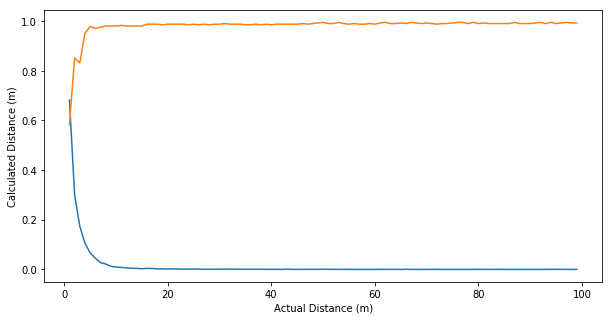

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline

fig= plt.figure(figsize=(10,5))
axes= fig.add_subplot(111)


axes.plot(epochX, costY)
plt.xlabel('Actual Distance (m)')
plt.ylabel('Calculated Distance (m)')

axes.plot(epochX, accuracyY)
#axes.set_yticks([0,10,20,30,40,50,60,70])
#plt.show()

#plt.savefig('graph7-04percentage.png',dpi=900)

## Prediction

In [27]:
y_pred = sess.run(tf.argmax(logits,1),feed_dict={X: X_test , keep_prob:1}) 
y_true = sess.run(tf.argmax(y_test,1))

In [28]:
# Ptint Result

from sklearn.metrics import precision_recall_fscore_support
p,r,f,s = precision_recall_fscore_support(y_true, y_pred, average='micro')
print("F-Score:", round(f,3))
from sklearn.metrics import accuracy_score
print("Accuracy: ", accuracy_score(y_true, y_pred))

from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_true, y_pred))

F-Score: 1.0
Accuracy:  1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       298
           1       1.00      1.00      1.00       214

   micro avg       1.00      1.00      1.00       512
   macro avg       1.00      1.00      1.00       512
weighted avg       1.00      1.00      1.00       512

[[298   0]
 [  0 214]]
